# Challenge 1 - Tic Tac Toe

In this lab you will perform deep learning analysis on a dataset of playing [Tic Tac Toe](https://en.wikipedia.org/wiki/Tic-tac-toe).

There are 9 grids in Tic Tac Toe that are coded as the following picture shows:

![Tic Tac Toe Grids](tttboard.jpg)

In the first 9 columns of the dataset you can find which marks (`x` or `o`) exist in the grids. If there is no mark in a certain grid, it is labeled as `b`. The last column is `class` which tells you whether Player X (who always moves first in Tic Tac Toe) wins in this configuration. Note that when `class` has the value `False`, it means either Player O wins the game or it ends up as a draw.

Follow the steps suggested below to conduct a neural network analysis using Tensorflow and Keras. You will build a deep learning model to predict whether Player X wins the game or not.

## Step 1: Data Engineering

This dataset is almost in the ready-to-use state so you do not need to worry about missing values and so on. Still, some simple data engineering is needed.

1. Read `tic-tac-toe.csv` into a dataframe.
1. Inspect the dataset. Determine if the dataset is reliable by eyeballing the data.
1. Convert the categorical values to numeric in all columns.
1. Separate the inputs and output.
1. Normalize the input data.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping # This callback allows you to stop the training if the validation error increases
from tensorflow.keras.callbacks import ModelCheckpoint # This callback allows you to save the model.

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/lab-deep-learning/your-code/tic-tac-toe.csv")
data.head()

,TL,TM,TR,ML,MM,MR,BL,BM,BR,class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


### Normalize all columns (except 'class')
* Change 'b' to 0.0  (Empty field)
* Change 'x' to 0.5  (Player 1)
* Change '0' to 1.0  (Player 2)

In [6]:
def clean_X(val):
  if val == 'b':
    return 0
  elif val == 'x':
    return 1
  return 2 

def clean_columns(data):
  df = data.copy()
  for col in df.columns:
    if col != 'class':
      df[col] = df[col].apply(clean_X)
    else:
      df[col] = df[col].apply(lambda x: 1 if x==True else 0)
  return df

In [7]:
data = clean_columns(data)
data

,TL,TM,TR,ML,MM,MR,BL,BM,BR,class
0,1,1,1,1,2,2,1,2,2,1
1,1,1,1,1,2,2,2,1,2,1
2,1,1,1,1,2,2,2,2,1,1
3,1,1,1,1,2,2,2,0,0,1
4,1,1,1,1,2,2,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...
953,2,1,1,1,2,2,2,1,1,0
954,2,1,2,1,1,2,1,2,1,0
955,2,1,2,1,2,1,1,2,1,0
956,2,1,2,2,1,1,1,2,1,0


In [8]:
data.dtypes

TL       int64
TM       int64
TR       int64
ML       int64
MM       int64
MR       int64
BL       int64
BM       int64
BR       int64
class    int64
dtype: object

In [9]:
data['class'].value_counts(dropna=False)

1    626
0    332
Name: class, dtype: int64

## Step 2: Build Neural Network

To build the neural network, you can refer to your own codes you wrote while following the [Deep Learning with Python, TensorFlow, and Keras tutorial](https://www.youtube.com/watch?v=wQ8BIBpya2k) in the lesson. It's pretty similar to what you will be doing in this lab.

1. Split the training and test data.
1. Create a `Sequential` model.
1. Add several layers to your model. Make sure you use ReLU as the activation function for the middle layers. Use Softmax for the output layer because each output has a single lable and all the label probabilities add up to 1.
1. Compile the model using `adam` as the optimizer and `sparse_categorical_crossentropy` as the loss function. For metrics, use `accuracy` for now.
1. Fit the training data.
1. Evaluate your neural network model with the test data.
1. Save your model as `tic-tac-toe.model`.

#### Do X/y and train/test split

In [10]:
X = data.drop(['class'], axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(670, 9)
(288, 9)


In [11]:
from sklearn.preprocessing import StandardScaler

trans = StandardScaler()
trans.fit(X_train)

X_train_trans = trans.transform(X_train)
X_test_trans  = trans.transform(X_test)

X_train = pd.DataFrame(X_train_trans, columns=X_train.columns)
X_test  = pd.DataFrame(X_test_trans,  columns=X_test.columns)

#### Create the model

In [12]:
model = keras.Sequential()

# Adding a hidden layer with:
# as many inputs as the number of features
# 9 neurons
# each neuron will have a "RELU" activation function
model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))

# Adding the final layer
model.add(Dense(2, activation='softmax'))

# Compile the final network
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


#### Fit model

In [13]:

# Here, the "patience" keyword controls how many iterations the network will
# do without improving the cost function before stopping.
early_stopping = EarlyStopping(patience=5) 

history = model.fit(
    X_train, 
    y_train, 
    epochs=60, 
    validation_split=0.20, 
    batch_size=20,
    verbose=2,
    callbacks=[early_stopping])

Epoch 1/60
27/27 - 1s - loss: 0.6778 - accuracy: 0.5653 - val_loss: 0.6214 - val_accuracy: 0.7015 - 1s/epoch - 44ms/step
Epoch 2/60
27/27 - 0s - loss: 0.6133 - accuracy: 0.6735 - val_loss: 0.5936 - val_accuracy: 0.6866 - 109ms/epoch - 4ms/step
Epoch 3/60
27/27 - 0s - loss: 0.5866 - accuracy: 0.6903 - val_loss: 0.5780 - val_accuracy: 0.6940 - 131ms/epoch - 5ms/step
Epoch 4/60
27/27 - 0s - loss: 0.5650 - accuracy: 0.7164 - val_loss: 0.5595 - val_accuracy: 0.7164 - 112ms/epoch - 4ms/step
Epoch 5/60
27/27 - 0s - loss: 0.5444 - accuracy: 0.7220 - val_loss: 0.5597 - val_accuracy: 0.7388 - 93ms/epoch - 3ms/step
Epoch 6/60
27/27 - 0s - loss: 0.5278 - accuracy: 0.7388 - val_loss: 0.5438 - val_accuracy: 0.7313 - 95ms/epoch - 4ms/step
Epoch 7/60
27/27 - 0s - loss: 0.5131 - accuracy: 0.7407 - val_loss: 0.5342 - val_accuracy: 0.7463 - 98ms/epoch - 4ms/step
Epoch 8/60
27/27 - 0s - loss: 0.4979 - accuracy: 0.7575 - val_loss: 0.5308 - val_accuracy: 0.7388 - 99ms/epoch - 4ms/step
Epoch 9/60
27/27 - 0s 

#### Evaluate model

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [15]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Train Accuracy:  {train_acc}')
print()
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy:  {test_acc}')

9/9 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.8229
Train Loss: 0.3422498404979706
Train Accuracy:  0.8776119351387024

Test Loss: 0.42194515466690063
Test Accuracy:  0.8229166865348816


In [16]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set
    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.yscale('log')
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


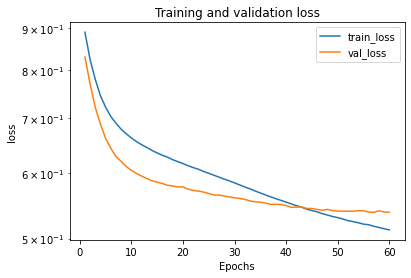

In [ ]:
plot_metric(history, 'loss')

#### Save model

In [17]:
model.save("/content/drive/MyDrive/lab-deep-learning/your-code/tic-tac-toe.model")

## Step 3: Make Predictions

Now load your saved model and use it to make predictions on a few random rows in the test dataset. Check if the predictions are correct.

In [18]:
# Load the model
new_model = tf.keras.models.load_model("/content/drive/MyDrive/lab-deep-learning/your-code/tic-tac-toe.model")

In [19]:
# Get random samples
samp   = data.sample(10)
print(samp)
X_samp = samp.drop('class', axis=1)
y_samp = samp['class']

# Predict
y_samp_pred = new_model.predict(X_samp)

     TL  TM  TR  ML  MM  MR  BL  BM  BR  class
28    1   1   1   2   2   0   1   0   2      1
399   2   2   1   0   1   0   1   2   1      1
84    1   1   2   1   0   2   1   2   0      1
689   1   2   1   0   2   0   0   2   1      0
393   2   2   1   0   1   1   1   0   2      1
551   0   2   1   0   1   1   2   2   1      1
209   1   2   0   2   1   2   1   0   1      1
654   1   1   2   0   2   2   1   1   2      0
704   1   2   0   0   2   0   1   2   1      0
642   1   1   2   2   2   1   2   0   1      0
1/1 [==============================] - 0s 51ms/step


In [20]:
d = {
    'Real Label'  :  y_samp,
    'Predicted Label'  : [np.argmax(row) for row in y_samp_pred]
}
pd.DataFrame(d)


,Real Label,Predicted Label
28,1,0
399,1,0
84,1,1
689,0,0
393,1,0
551,1,0
209,1,0
654,0,0
704,0,0
642,0,0


## Step 4: Improve Your Model

Did your model achieve low loss (<0.1) and high accuracy (>0.95)? If not, try to improve your model.

But how? There are so many things you can play with in Tensorflow and in the next challenge you'll learn about these things. But in this challenge, let's just do a few things to see if they will help.

* Add more layers to your model. If the data are complex you need more layers. But don't use more layers than you need. If adding more layers does not improve the model performance you don't need additional layers.
* Adjust the learning rate when you compile the model. This means you will create a custom `tf.keras.optimizers.Adam` instance where you specify the learning rate you want. Then pass the instance to `model.compile` as the optimizer.
    * `tf.keras.optimizers.Adam` [reference](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
    * Don't worry if you don't understand what the learning rate does. You'll learn about it in the next challenge.
* Adjust the number of epochs when you fit the training data to the model. Your model performance continues to improve as you train more epochs. But eventually it will reach the ceiling and the performance will stay the same.

In [23]:
# your code here
model = keras.Sequential()

model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(units=64, activation='relu'))

model.add(Dense(2, activation='softmax', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1280      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9,666
Trainable params: 9,666
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stopping = EarlyStopping(patience=5) 
history = model.fit(X_train, y_train, epochs=50, validation_split=0.20, 
                    batch_size=10, callbacks=[early_stopping])

Epoch 1/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0582 - accuracy: 0.9963 - val_loss: 0.3787 - val_accuracy: 0.8284
Epoch 2/50
54/54 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9963 - val_loss: 0.3426 - val_accuracy: 0.8433
Epoch 3/50
54/54 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9981 - val_loss: 0.3571 - val_accuracy: 0.8657
Epoch 4/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0448 - accuracy: 0.9981 - val_loss: 0.3336 - val_accuracy: 0.8806
Epoch 5/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 0.3570 - val_accuracy: 0.8433
Epoch 6/50
54/54 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.3623 - val_accuracy: 0.8731
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 0.0364 - accuracy: 0.9981 - val_loss: 0.3536 - val_accuracy: 0.8582
Epoch 8/50
54/54 [==

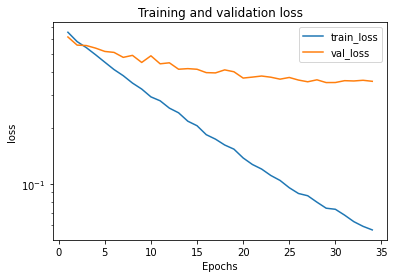

In [25]:
plot_metric(history, 'loss')

In [27]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Train Accuracy:  {train_acc}')
print()
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy:  {test_acc}')

9/9 [==============================] - 0s 2ms/step - loss: 0.2346 - accuracy: 0.9097
Train Loss: 0.0923219844698906
Train Accuracy:  0.9746268391609192

Test Loss: 0.23460906744003296
Test Accuracy:  0.9097222089767456


**Which approach(es) did you find helpful to improve your model performance?**

Adding a hidden layer and setting the learning rate increased the accuracy and decreased the loss.